In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [147]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cpu
0.10.0+cpu


In [148]:
train_data_path = "../data/train/"
test_data_path = "../data/test/"

In [149]:
transforms = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])
])

In [150]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms)

In [151]:
print("Num Images in Train Dataset:", len(train_data))
print("Num Images in Test Dataset:", len(test_data))

Num Images in Train Dataset: 3416
Num Images in Test Dataset: 373


In [152]:
batch_size=16
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size,num_workers=8)

In [153]:
len(train_data)

3416

In [154]:
len(train_data.targets)

3416

In [155]:
batch = next(iter(train_data_loader))

In [156]:
images, labels = batch

In [157]:
images.shape

torch.Size([16, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([14,  2,  8, 14,  2, 14, 15, 15,  2, 14,  8, 15, 15, 14,  2, 15])


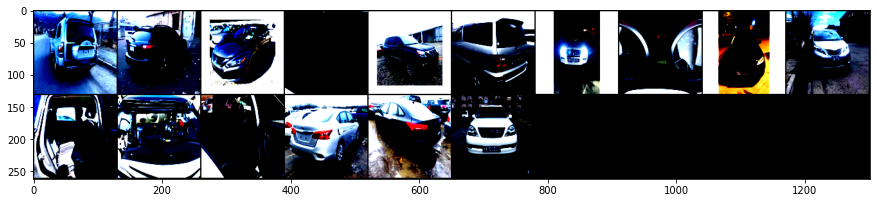

In [158]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("Labels:", labels)

In [159]:
grid.shape

torch.Size([3, 262, 1302])

In [160]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*29*29, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=16)
    def forward(self, x):
        # (1) input layer
        x = x
        
        # (2) hidden conv layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        x = x.reshape(-1, 12*29*29)
        x = self.fc1(x)
        x = F.relu(x)

        # (5) hidden linear layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # (6) output layer
        x = self.fc3(x)
        # x = F.softmax(x, dim=1)
        return x
network = Net()

In [161]:
sample = next(iter(train_data))

In [162]:
image,label = sample
image.shape

torch.Size([3, 128, 128])

In [163]:
image.unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [164]:
pred = network(image.unsqueeze(0))

In [165]:
pred.shape

torch.Size([1, 16])

In [166]:
pred.argmax(dim=1)

tensor([10])

In [167]:
batch = next(iter(train_data_loader))

In [168]:
images,labels = batch

**Calculating the loss**

In [169]:
preds = network(images)

In [170]:
loss = F.cross_entropy(preds,labels)
loss.item()

2.795827627182007

**Calculating gradients**

In [171]:
print(network.conv1.weight.grad)

None


In [172]:
loss.backward()  # Calculating gradients

In [173]:
network.conv1.weight.grad.shape

torch.Size([6, 3, 5, 5])

**Updating the Weights**

In [174]:
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [175]:
loss.item()

2.795827627182007

**TensorBoard**

In [131]:
tb = SummaryWriter()

network = Net()
images, labels = next(iter(train_data_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network,images)
tb.close()


In [176]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [177]:
for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_data_loader:
        images,labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds,labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        total_correct+=get_num_correct(preds, labels)
    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)


epoch: 0 total_correct: 1262 loss: 395.8620955944061
epoch: 1 total_correct: 1444 loss: 357.9068092107773
epoch: 2 total_correct: 1654 loss: 314.92609882354736
epoch: 3 total_correct: 2027 loss: 249.75988414883614
epoch: 4 total_correct: 2582 loss: 155.96256464719772


In [178]:
get_num_correct(preds,labels)

3

In [179]:
preds = network(images)
loss = F.cross_entropy(preds,labels)

In [180]:
loss.item()

1.0663083791732788

In [181]:
get_num_correct(preds,labels)

6

In [182]:
preds.shape

torch.Size([8, 16])

In [183]:
preds

tensor([[ -2.9234,  -3.0267,   2.7970,  -1.2162,  -3.8642,  -1.6541, -10.3996,
          -5.1411,  -0.6387,  -4.1192,  -7.9030,  -2.3109,  -9.6429,  -3.7526,
           4.1936,   3.0521],
        [ -2.5058,  -4.1703,   1.3521,  -0.2998,  -3.6923,   1.4316,  -3.3278,
          -4.0829,   0.9451,  -1.6420,  -5.2179,  -1.3700,  -1.3802,   0.2556,
          -2.6133,   0.2833],
        [ -4.9936,  -5.0870,   5.1371,   3.0242,  -4.0475,  -2.4709, -11.7558,
          -6.8317,  -2.3565,  -1.8598,  -5.3323,  -3.2202,  -6.9603,  -5.9475,
           0.5772,   1.2778],
        [ -1.4288,  -0.5956,   0.2861,  -1.0222,  -3.4487,  -1.3787,  -5.0365,
          -0.8706,   0.3970,  -5.3404,  -6.0691,  -1.9602,  -4.9362,  -2.0511,
           3.6257,   1.0278],
        [ -3.8970,  -1.4046,  -0.1236,   0.8286,  -6.8527,  -3.0283,  -8.7802,
          -1.8419,   1.2325,  -7.7911,  -8.4861,  -2.7713, -11.9243,  -3.9096,
           5.9566,   3.3840],
        [ -3.9325,  -2.1639,   0.2379,  -1.2482,  -4.5347,  

In [184]:
preds.argmax(dim=1)

tensor([14,  5,  2, 14, 14, 14, 15, 15])

In [185]:
preds.argmax(dim=1).eq(labels)

tensor([ True,  True,  True,  True,  True,  True, False, False])

In [186]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [187]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = np.argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [188]:
# evaluate the model
acc = evaluate_model(test_data_loader, network)
print('Accuracy: %.3f' % acc)

Accuracy: 0.421
